<a href="https://colab.research.google.com/github/AAAngieShao/IntroToGit/blob/main/2023_03_22_Puzzle_5_Music_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Warm-up Puzzle
### CS 5787, March 22th, 2023

This notebook contains Python code for loading the [Million Song music dataset](https://labrosa.ee.columbia.edu/millionsong/) (the one we used in homework 2!) and predicting features using mean squared error. The code uses [lightning](https://lightning.ai/pages/open-source/) to set up training. Lightning handles a lot of the internal boilerplate training code that we previously had to write ourselves – the loop, for example, optimizer, and `loss.backward()` stuff are noticeably absent.

But there's a problem. After training the network, the train loss is much much higher than the test loss. This is similar to an instance of 'underfitting', which we've observed in the deep learning setting – but is that what's happening? Or is something else wrong? Find the bug and fix it so the train and test loss are on the same scale.

Bonus exercises:
- Track accuracy and plot it over training in a graph next to the loss graph. Bonus points for using built-in lightning tools 
- Try to improve MSE in any way you can. You can change the data preprocessing, adjust the architecture of the network, or change the hyperparameters of training.

In [1]:
!pip install pytorch_lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 715.6/715.6 KB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 4.6 MB/s eta 0:00:00


In [5]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
!unzip YearPredictionMSD.txt.zip

from typing import Tuple

import numpy as np
import pandas as pd

def loadMusicData(fname: str, addBias: bool) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
  df = pd.read_csv(fname, header=None)

  if addBias:
    ones = [1] * len(df)
    df.insert(len(df.columns), 'bias', ones)
        

  data = df.to_numpy()

  split_idx = 463_714
  train_data = data[:split_idx]
  test_data = data[split_idx:]

  trainYears = train_data[:, 0]
  trainFeat = train_data[:, 1:]

  testYears = test_data[:, 0]
  testFeat = test_data[:, 1:]

  return trainYears, trainFeat, testYears, testFeat


trainYears, trainFeat, testYears, testFeat = loadMusicData(fname='YearPredictionMSD.txt', addBias=False)

--2023-03-22 14:02:36--  https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 211011981 (201M) [application/x-httpd-php]
Saving to: ‘YearPredictionMSD.txt.zip’

YearPredictionMSD.t 100%[===================>] 201.24M  15.4MB/s    in 14s     

2023-03-22 14:02:50 (14.8 MB/s) - ‘YearPredictionMSD.txt.zip’ saved [211011981/211011981]

Archive:  YearPredictionMSD.txt.zip
  inflating: YearPredictionMSD.txt   


In [6]:
train_means = trainFeat.mean(axis=0)
train_stds = trainFeat.std(axis=0)

X_train = (trainFeat - train_means[None]) / train_stds[None]
Y_train = trainYears

test_means = testFeat.mean(axis=0)
test_stds = testFeat.std(axis=0)

X_test = (testFeat - test_means[None]) / test_stds[None]
Y_test = testYears

In [7]:
import collections

import pytorch_lightning as pl
import torch

num_features = X_train.shape[1] # should be 91
class SmallNetwork(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.network = torch.nn.Sequential(
            torch.nn.Linear(num_features, 10),
            torch.nn.GELU(),
            torch.nn.Linear(10, 1)
        )
        self.losses = collections.defaultdict(dict) # dict for tracking losses

    def forward(self, x):
        return self.network(x.float())

    def training_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self(x)
        train_loss = ((y - y_hat) ** 2).sum() / len(batch)
        self.log("train_loss", train_loss, prog_bar=True)
        self.losses["train"][self.global_step] = train_loss.item()
        return train_loss

    def validation_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self(x)
        val_loss = ((y - y_hat) ** 2).mean()
        self.log("val_loss", val_loss, prog_bar=True)
        self.losses["val"][self.global_step] = val_loss.item()
        return val_loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.02)

In [ ]:
# Init our model
model = SmallNetwork()

# Initialize dataloaders from music data
train_loader = torch.utils.data.DataLoader(list(zip(X_train, Y_train)), batch_size=1024)
val_loader = torch.utils.data.DataLoader(list(zip(X_test, Y_test)), batch_size=1024)

# Initialize a trainer
trainer = pl.Trainer(
    accelerator="auto",
    devices=1,
    max_epochs=5,
    val_check_interval=(1/10.), # validate 10x per epoch :-)
)

# Train the model ⚡
trainer.fit(model, train_loader, val_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type       | Params
---------------------------------------
0 | network | Sequential | 921   
---------------------------------------
921       Trainable params
0         Non-trainable params
921       Total params
0.004     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [ ]:
final_train_loss = trainer.logged_metrics["train_loss"]
final_val_loss = trainer.logged_metrics["val_loss"]
print(f"Final losses: {final_train_loss:.2f} train / {final_val_loss:.2f}")

Final losses: 3505642010.00 train / 8853.05


Text(0.5, 1.0, 'Loss curves for music data')

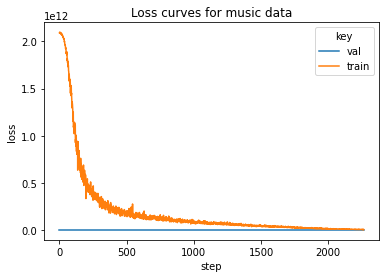

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

data = []

logged_losses = trainer.model.losses
for key in logged_losses:
  for step, loss in logged_losses[key].items():
    data.append([key, step, loss])

loss_df = pd.DataFrame(data, columns=['key', 'step', 'loss'])

sns.lineplot(data=loss_df, x='step', y='loss', hue="key")
plt.title("Loss curves for music data")